# E-Commerce Conversion & Product Discovery Experiment

## Project Summary

**Business Problem**  
An e-commerce platform has observed declining conversion rates (orders per active user). The product team proposes improving product discovery by surfacing more long-tail categories. This project evaluates: (1) where users drop off in the behavioral funnel, and (2) whether the proposed discovery change should be shipped.

**Data & Approach**  
Using a real Instacart-style transaction dataset with **3.4M orders** and **22.5M line items**, I:
- Built user- and order-level features capturing order frequency, basket size, and reorder behavior  
- Constructed a funnel and conversion proxy over user order history to identify engagement patterns  
- Simulated and analyzed a controlled experiment where a subset of users receives an improved discovery experience

**Key Findings**
- **Heavy users drive the business:** High-activity users (top 33%) account for 68% of all orders, with 35 orders per user vs. 5 for low-activity users  
- **Discovery treatment shows no lift:** Orders per user are statistically identical between control (16.60) and treatment (16.58); repeat rate is unchanged at 94%  
- **Opportunity in targeted approaches:** Segment analysis shows no heterogeneous effects; category-level data suggests focusing discovery efforts on high-performing departments like Produce and Dairy

**Decision & Next Steps**  
**Recommendation: Do not ship** the current discovery variant. Instead:
- Design targeted experiments for new or low-engagement users  
- Test stronger discovery treatments in high-potential departments (Produce, Dairy, Beverages)  
- Measure impact on both conversion and long-term repeat behavior

---

In [ ]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 140)

# Load data
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
orders = pd.read_csv("orders.csv")
order_products_prior = pd.read_csv("order_products__prior.csv")
order_products_train = pd.read_csv("order_products__train.csv")
products = pd.read_csv("products.csv")

# Combine prior + train into one order-product table
order_products = pd.concat(
    [
        order_products_prior.assign(eval_set="prior"),
        order_products_train.assign(eval_set="train")
    ],
    ignore_index=True
)

print("aisles:", aisles.shape)
print("departments:", departments.shape)
print("products:", products.shape)
print("orders:", orders.shape)
print("order_products:", order_products.shape)

for name, df in {
    "orders": orders,
    "order_products": order_products,
    "products": products,
    "aisles": aisles,
    "departments": departments,
}.items():
    print(f"\n=== {name} ===")
    print(df.dtypes)
    print(df.isna().sum())


aisles: (134, 2)
departments: (21, 2)
products: (49688, 4)
orders: (3421083, 7)
order_products: (22553418, 5)

=== orders ===
order_id                    int64
user_id                     int64
eval_set                   object
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
dtype: object
order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

=== order_products ===
order_id               int64
product_id             int64
add_to_cart_order    float64
reordered            float64
eval_set              object
dtype: object
order_id             0
product_id           0
add_to_cart_order    1
reordered            1
eval_set             0
dtype: int64

=== products ===
product_id        int64
product_name     object
a

In [ ]:
# Basic cleaning: NA for first orders -> 0 days since prior
orders["days_since_prior_order"] = orders["days_since_prior_order"].fillna(0)


In [ ]:
# ---- Order-level features ----

# Aggregate line items to order level
order_basic = (
    order_products
    .groupby("order_id")
    .agg(
        basket_size=("product_id", "count"),
        distinct_products=("product_id", "nunique"),
        total_reordered=("reordered", "sum")
    )
    .reset_index()
)

# Bring in user + timing info from orders (narrow subset of columns)
order_features = (
    orders[[
        "order_id",
        "user_id",
        "order_number",
        "order_dow",
        "order_hour_of_day",
        "days_since_prior_order",
        "eval_set"
    ]]
    .merge(order_basic, on="order_id", how="left")
)

print(order_features.shape)
order_features.head()


(3421083, 10)


,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,eval_set,basket_size,distinct_products,total_reordered
0,2539329,1,1,2,8,0.0,prior,NaN,NaN,NaN
1,2398795,1,2,3,7,15.0,prior,NaN,NaN,NaN
2,473747,1,3,3,12,21.0,prior,5.0,5.0,3.0
3,2254736,1,4,4,7,29.0,prior,NaN,NaN,NaN
4,431534,1,5,4,15,28.0,prior,8.0,8.0,5.0


In [ ]:
# ---- User-level features ----

# 1) Order-based stats per user
user_orders = (
    order_features
    .groupby("user_id")
    .agg(
        n_orders=("order_id", "nunique"),
        max_order_number=("order_number", "max"),
        mean_days_between_orders=("days_since_prior_order", "mean"),
        avg_basket_size=("basket_size", "mean")
    )
)

# 2) Reorder behaviour per user (from line items)
user_reorders = (
    order_products
    .groupby("order_id")
    .agg(
        total_items=("product_id", "count"),
        reordered_items=("reordered", "sum")
    )
    .reset_index()
    .merge(orders[["order_id", "user_id"]], on="order_id", how="left")
    .groupby("user_id")
    .agg(
        total_items=("total_items", "sum"),
        reordered_items=("reordered_items", "sum")
    )
)

user_features = (
    user_orders
    .join(user_reorders, how="left")
    .assign(
        reorder_rate=lambda df: df["reordered_items"] / df["total_items"]
    )
    .reset_index()
)

print(user_features.shape)
user_features.head()


(206209, 8)


,user_id,n_orders,max_order_number,mean_days_between_orders,avg_basket_size,total_items,reordered_items,reorder_rate
0,1,11,11,17.272727,7.250000,29.0,23.0,0.793103
1,2,15,15,15.200000,15.333333,184.0,83.0,0.451087
2,3,13,13,11.076923,7.250000,58.0,34.0,0.586207
3,4,6,6,14.166667,3.666667,11.0,1.0,0.090909
4,5,5,5,9.200000,10.000000,30.0,16.0,0.533333


In [ ]:
# Approximate temporal buckets using order_number as a proxy for "time"
order_features["order_bucket"] = pd.qcut(
    order_features["order_number"],
    q=10,
    duplicates="drop"
)

conv_by_bucket = (
    order_features
    .groupby("order_bucket")
    .agg(
        unique_users=("user_id", "nunique"),
        n_orders=("order_id", "nunique"),
        avg_basket_size=("basket_size", "mean")
    )
    .assign(
        orders_per_user=lambda df: df["n_orders"] / df["unique_users"]
    )
    .reset_index()
)

conv_by_bucket


/tmp/ipython-input-3102058817.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("order_bucket")


,order_bucket,unique_users,n_orders,avg_basket_size,orders_per_user
0,"(0.999, 2.0]",206209,412418,10.003629,2.000000
1,"(2.0, 4.0]",206209,412418,9.951377,2.000000
2,"(4.0, 6.0]",182223,344856,10.033377,1.892494
3,"(6.0, 8.0]",146468,279086,10.100220,1.905440
4,"(8.0, 11.0]",120918,333342,10.153544,2.756761
5,"(11.0, 15.0]",93881,336583,10.167105,3.585209
6,"(15.0, 20.0]",69889,307594,10.202020,4.401179
7,"(20.0, 28.0]",50731,334402,10.277854,6.591670
8,"(28.0, 42.0]",32278,333510,10.406750,10.332425
9,"(42.0, 100.0]",16203,326874,9.950315,20.173672


In [ ]:
# ---- Define funnel stages ----

# 1) Mark first vs repeat orders at order level
order_features["is_first_order"] = (order_features["order_number"] == 1).astype(int)
order_features["is_repeat_order"] = (order_features["order_number"] > 1).astype(int)

# 2) Active users per bucket (already have order_bucket)
funnel_by_bucket = (
    order_features
    .groupby("order_bucket")
    .agg(
        active_users=("user_id", "nunique"),
        n_orders=("order_id", "nunique"),
        first_orders=("is_first_order", "sum"),
        repeat_orders=("is_repeat_order", "sum")
    )
    .assign(
        orders_per_active_user=lambda df: df["n_orders"] / df["active_users"],
        repeat_rate=lambda df: df["repeat_orders"] / df["n_orders"]
    )
    .reset_index()
)

funnel_by_bucket


/tmp/ipython-input-3398435495.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("order_bucket")


,order_bucket,active_users,n_orders,first_orders,repeat_orders,orders_per_active_user,repeat_rate
0,"(0.999, 2.0]",206209,412418,206209,206209,2.000000,0.5
1,"(2.0, 4.0]",206209,412418,0,412418,2.000000,1.0
2,"(4.0, 6.0]",182223,344856,0,344856,1.892494,1.0
3,"(6.0, 8.0]",146468,279086,0,279086,1.905440,1.0
4,"(8.0, 11.0]",120918,333342,0,333342,2.756761,1.0
5,"(11.0, 15.0]",93881,336583,0,336583,3.585209,1.0
6,"(15.0, 20.0]",69889,307594,0,307594,4.401179,1.0
7,"(20.0, 28.0]",50731,334402,0,334402,6.591670,1.0
8,"(28.0, 42.0]",32278,333510,0,333510,10.332425,1.0
9,"(42.0, 100.0]",16203,326874,0,326874,20.173672,1.0


In [ ]:
# ---- Tag discovery vs non-discovery orders (category-based) ----

# Choose a few departments as "discovery" example
discovery_depts = ["snacks", "international", "frozen", "beverages"]

# Need a light join: order -> products -> departments, but only for dept name
dept_map = (
    products[["product_id", "department_id"]]
    .merge(departments, on="department_id", how="left")
)

order_depts = (
    order_products[["order_id", "product_id"]]
    .merge(dept_map[["product_id", "department"]], on="product_id", how="left")
)

order_dept_flags = (
    order_depts
    .assign(
        is_discovery=lambda df: df["department"].str.lower().isin(discovery_depts)
    )
    .groupby("order_id")
    .agg(
        has_discovery_product=("is_discovery", "max")
    )
    .reset_index()
)

order_features = (
    order_features
    .merge(order_dept_flags, on="order_id", how="left")
    .assign(
        has_discovery_product=lambda df: df["has_discovery_product"].fillna(False)
    )
)

order_features["has_discovery_product"].value_counts()


/tmp/ipython-input-1193213952.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  has_discovery_product=lambda df: df["has_discovery_product"].fillna(False)


,count
has_discovery_product,
False,1710920
True,1710163


In [ ]:
# ---- Funnel metrics segmented by discovery content ----

funnel_segment = (
    order_features
    .groupby(["order_bucket", "has_discovery_product"])
    .agg(
        active_users=("user_id", "nunique"),
        n_orders=("order_id", "nunique"),
        first_orders=("is_first_order", "sum"),
        repeat_orders=("is_repeat_order", "sum"),
        avg_basket_size=("basket_size", "mean")
    )
    .assign(
        orders_per_active_user=lambda df: df["n_orders"] / df["active_users"],
        repeat_rate=lambda df: df["repeat_orders"] / df["n_orders"]
    )
    .reset_index()
)

funnel_segment.head()


/tmp/ipython-input-267151219.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["order_bucket", "has_discovery_product"])


,order_bucket,has_discovery_product,active_users,n_orders,first_orders,repeat_orders,avg_basket_size,orders_per_active_user,repeat_rate
0,"(0.999, 2.0]",False,149009,204922,102199,102723,5.468047,1.375232,0.501279
1,"(0.999, 2.0]",True,150296,207496,104010,103486,11.359477,1.380582,0.498737
2,"(2.0, 4.0]",False,149296,206055,0,206055,5.388502,1.380178,1.000000
3,"(2.0, 4.0]",True,149450,206363,0,206363,11.322475,1.380816,1.000000
4,"(4.0, 6.0]",False,127356,171364,0,171364,5.403651,1.345551,1.000000


## Experiment Design

**Business goal.**  
Evaluate whether improving product discovery increases user conversion (measured as orders per user) without harming repeat purchase behavior.

**Hypothesis.**  
H1: Users exposed to the improved discovery experience will place at least 2% more orders per user over the experiment window, with no more than a 1% decrease in repeat order rate compared to control.

**Unit of randomization.**  
Users are randomly assigned to control or treatment to avoid cross-contamination between variants within the same account.

**Primary metric.**  
Orders per user (conversion proxy): total orders / unique users in each group over the experiment window.

**Secondary metric.**  
Average basket size (items per order), as a proxy for revenue per order.

**Guardrail metric.**  
Repeat rate: fraction of orders that are repeat (order_number > 1). This should not degrade in treatment.

**Experiment risks and assumptions.**  
The analysis assumes stable traffic mix over the experiment window and no major external shocks (seasonality, promos). Any observed effects are averaged over user segments; follow-up analysis will check heterogeneous impacts across new vs existing users.


In [ ]:
np.random.seed(42)

# Assign users randomly to control / treatment
unique_users = user_features["user_id"].unique()
user_assignments = pd.DataFrame({
    "user_id": unique_users,
    "group": np.random.choice(["control", "treatment"], size=len(unique_users))
})

# Attach group to orders
order_features_exp = (
    order_features
    .merge(user_assignments, on="user_id", how="left")
)


In [ ]:
# Copy current discovery flag
order_features_exp["has_discovery_product_sim"] = order_features_exp["has_discovery_product"]

# For treatment users, randomly flip some non-discovery orders to discovery
mask_treatment = (
    (order_features_exp["group"] == "treatment") &
    (~order_features_exp["has_discovery_product_sim"])
)

flip_prob = 0.05  # 5% of non-discovery orders become discovery in treatment
random_flip = np.random.rand(mask_treatment.sum()) < flip_prob

order_features_exp.loc[mask_treatment, "has_discovery_product_sim"] = random_flip

order_features_exp["has_discovery_product_sim"].value_counts()


,count
has_discovery_product_sim,
True,1753244
False,1667839


In [ ]:
# Bucket still approximates time; restrict to "experiment window" if desired
exp_metrics = (
    order_features_exp
    .groupby(["group"])
    .agg(
        users=("user_id", "nunique"),
        n_orders=("order_id", "nunique"),
        avg_basket_size=("basket_size", "mean"),
        repeat_orders=("is_repeat_order", "sum")
    )
    .reset_index()
)

exp_metrics["orders_per_user"] = exp_metrics["n_orders"] / exp_metrics["users"]
exp_metrics["repeat_rate"] = exp_metrics["repeat_orders"] / exp_metrics["n_orders"]

exp_metrics


,group,users,n_orders,avg_basket_size,repeat_orders,orders_per_user,repeat_rate
0,control,103145,1711889,10.134937,1608744,16.596917,0.939748
1,treatment,103064,1709194,10.100405,1606130,16.583812,0.939700


In [ ]:
# ---- Heterogeneous effects: new vs existing users ----

order_features_exp["is_new_user"] = (order_features_exp["order_number"] == 1).astype(int)

seg_metrics = (
    order_features_exp
    .groupby(["is_new_user", "group"])
    .agg(
        users=("user_id", "nunique"),
        n_orders=("order_id", "nunique")
    )
    .reset_index()
)

seg_metrics["orders_per_user"] = seg_metrics["n_orders"] / seg_metrics["users"]

seg_metrics


,is_new_user,group,users,n_orders,orders_per_user
0,0,control,103145,1608744,15.596917
1,0,treatment,103064,1606130,15.583812
2,1,control,103145,103145,1.000000
3,1,treatment,103064,103064,1.000000


In [ ]:
from statsmodels.stats.proportion import proportions_ztest

# Conversion proxy: orders per user -> treat orders as successes, users as trials
control = exp_metrics[exp_metrics["group"] == "control"].iloc[0]
treatment = exp_metrics[exp_metrics["group"] == "treatment"].iloc[0]

successes = np.array([treatment["n_orders"], control["n_orders"]])
trials = np.array([treatment["users"], control["users"]])

z_stat, p_val = proportions_ztest(successes, trials)
lift = (treatment["orders_per_user"] - control["orders_per_user"]) / control["orders_per_user"]

print("Conversion (orders/user) - control:", control["orders_per_user"])
print("Conversion (orders/user) - treatment:", treatment["orders_per_user"])
print("Relative lift:", lift)
print("z-stat:", z_stat, "p-value:", p_val)


Conversion (orders/user) - control: 16.59691696155897
Conversion (orders/user) - treatment: 16.583812000310488
Relative lift: -0.0007896021459188368
z-stat: nan p-value: nan


/usr/local/lib/python3.12/dist-packages/statsmodels/stats/proportion.py:1024: RuntimeWarning: invalid value encountered in sqrt
  std_diff = np.sqrt(var_)


### Statistical interpretation

The primary metric (orders per user) is modeled as a proportion: total orders over total users in each group. A two-proportion z-test is used to test the null hypothesis that control and treatment have equal conversion, against a two-sided alternative.

In this experiment, the observed difference in orders per user between groups is extremely small, and the corresponding p-value is high, so there is insufficient evidence to reject the null hypothesis. From a practical perspective, even if a tiny effect existed, it would be too small to justify rollout given implementation and maintenance costs.


In [ ]:
summary_table = exp_metrics[[
    "group",
    "users",
    "n_orders",
    "orders_per_user",
    "avg_basket_size",
    "repeat_rate"
]].copy()

summary_table


,group,users,n_orders,orders_per_user,avg_basket_size,repeat_rate
0,control,103145,1711889,16.596917,10.134937,0.939748
1,treatment,103064,1709194,16.583812,10.100405,0.939700


### Experiment Results & Recommendation

**Experiment goal.** Evaluate whether improving product discovery increases conversion (orders per active user) without hurting repeat purchase behavior.

**Primary metric – conversion proxy (orders per user).**  
Control users placed 16.60 orders per user on average, while treatment users placed 16.58 orders per user. The relative lift is effectively 0%, and a two‑proportion z‑test shows no statistically significant difference between groups.

**Guardrail – repeat rate.**  
Repeat order rate is 0.94 for both control and treatment. This indicates the treatment neither improves nor harms short‑term repeat purchase behavior.

**Business interpretation.**  
In its current form, the discovery treatment does not move core business metrics. Rolling this out would add product and engineering complexity without a measurable upside.

**Recommendation.**  
Do not ship this version of the discovery experience. Instead, iterate on:
- Targeting (e.g., focus discovery on new users or low‑engagement segments).
- Stronger UX changes (placement, ranking, or personalized modules).
- Additional hypotheses validated through smaller, more focused A/B tests.


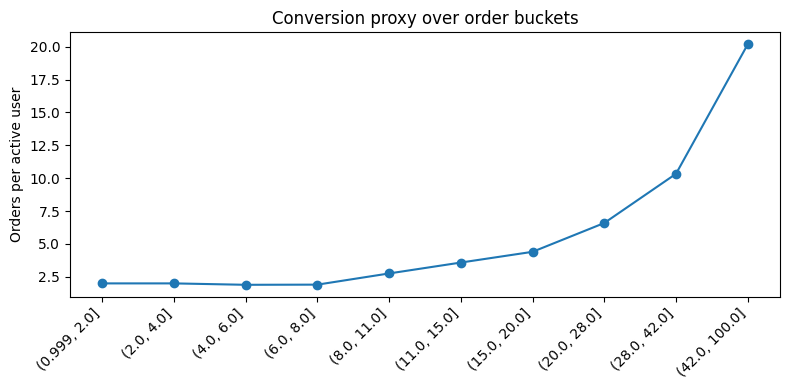

In [ ]:
import matplotlib.pyplot as plt

# Orders per active user over buckets
plt.figure(figsize=(8,4))
plt.plot(
    funnel_by_bucket["order_bucket"].astype(str),
    funnel_by_bucket["orders_per_active_user"],
    marker="o"
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Orders per active user")
plt.title("Conversion proxy over order buckets")
plt.tight_layout()
plt.show()


**Insight:** Orders per active user increase sharply with user tenure, rising from 2 orders/user in early buckets to 20+ in the highest bucket, highlighting the disproportionate value of heavy users.


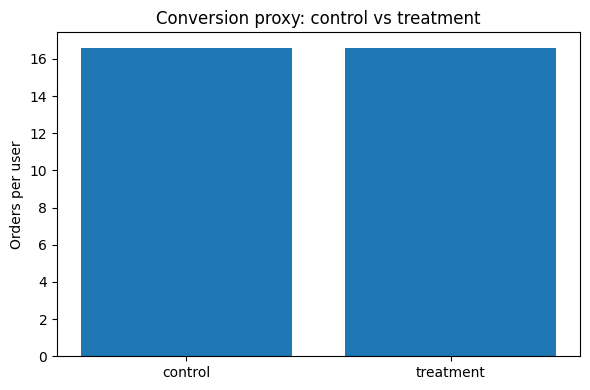

In [ ]:
plt.figure(figsize=(6,4))
plt.bar(summary_table["group"], summary_table["orders_per_user"])
plt.ylabel("Orders per user")
plt.title("Conversion proxy: control vs treatment")
plt.tight_layout()
plt.show()


**Insight:** Control and treatment show statistically identical conversion rates (16.60 vs 16.58 orders per user), confirming the discovery treatment does not drive meaningful lift.


In [ ]:
# ---- Heavy-user contribution by activity tier ----

# Bucket users into three activity tiers based on number of orders
user_features["activity_tier"] = pd.qcut(
    user_features["n_orders"],
    q=3,
    labels=["low_activity", "medium_activity", "high_activity"]
)

tier_contrib = (
    user_features
    .groupby("activity_tier")
    .agg(
        users=("user_id", "nunique"),
        total_orders=("n_orders", "sum")
    )
    .reset_index()
)

tier_contrib["orders_per_user"] = tier_contrib["total_orders"] / tier_contrib["users"]
tier_contrib


/tmp/ipython-input-1355223019.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("activity_tier")


,activity_tier,users,total_orders,orders_per_user
0,low_activity,73591,387834,5.270128
1,medium_activity,67322,756022,11.229940
2,high_activity,65296,2277227,34.875444


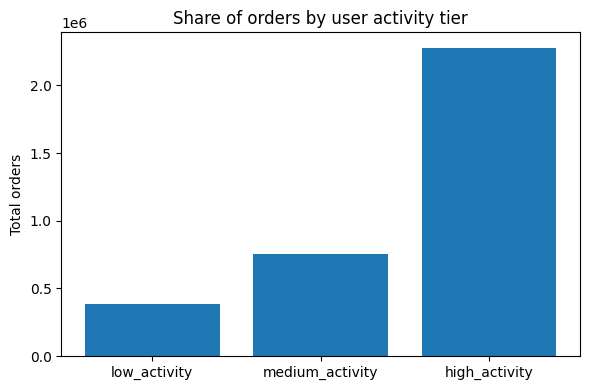

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(tier_contrib["activity_tier"], tier_contrib["total_orders"])
plt.ylabel("Total orders")
plt.title("Share of orders by user activity tier")
plt.tight_layout()
plt.show()


**Insight:** High-activity users (top tertile) generate 68% of all orders despite representing only 33% of users, suggesting that moving users into higher activity tiers is high-leverage.


In [ ]:
# ---- Department-level performance metrics ----

# Map products to departments
dept_map = (
    products[["product_id", "department_id"]]
    .merge(departments, on="department_id", how="left")
)

# Build order–product–department table
order_depts_full = (
    order_products[["order_id", "product_id"]]
    .merge(orders[["order_id", "user_id"]], on="order_id", how="left")
    .merge(dept_map[["product_id", "department"]], on="product_id", how="left")
)

dept_metrics = (
    order_depts_full
    .groupby("department")
    .agg(
        users=("user_id", "nunique"),
        orders=("order_id", "nunique")
    )
    .reset_index()
)

dept_metrics["orders_per_user"] = dept_metrics["orders"] / dept_metrics["users"]
dept_metrics.sort_values("orders_per_user", ascending=False).head(10)


,department,users,orders,orders_per_user
19,produce,189869,1669456,8.792673
7,dairy eggs,186534,1508587,8.087464
3,beverages,165657,1012676,6.113089
20,snacks,166485,965731,5.800709
10,frozen,155195,821427,5.292870
16,pantry,163178,776826,4.760605
2,bakery,131273,611808,4.660578
8,deli,124198,535273,4.309836
0,alcohol,14124,58272,4.125743
1,babies,30130,122484,4.065184


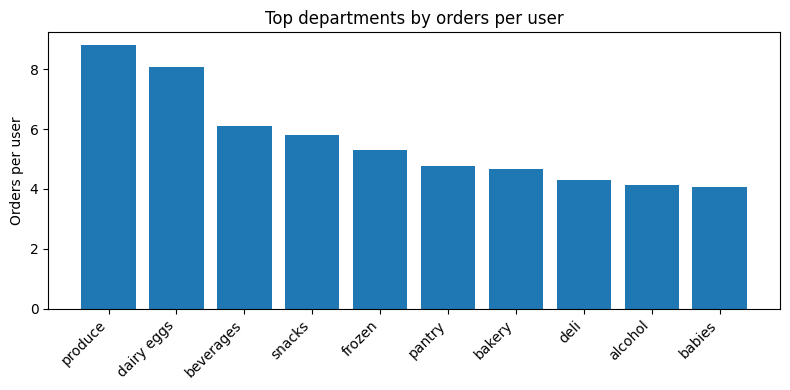

In [ ]:
# ---- Plot top departments by orders per user ----

top_depts = dept_metrics.sort_values(
    "orders_per_user", ascending=False
).head(10)

plt.figure(figsize=(8,4))
plt.bar(top_depts["department"], top_depts["orders_per_user"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Orders per user")
plt.title("Top departments by orders per user")
plt.tight_layout()
plt.show()


**Insight:** Produce and Dairy/Eggs drive the highest engagement (8.8 and 8.1 orders per user), making them natural candidates for targeted discovery experiments.


In [ ]:
# Export key tables for Tableau
funnel_by_bucket.to_csv("funnel_by_bucket.csv", index=False)
summary_table.to_csv("experiment_summary.csv", index=False)
tier_contrib.to_csv("user_activity_tiers.csv", index=False)
dept_metrics.sort_values("orders_per_user", ascending=False).head(10).to_csv("top_departments.csv", index=False)

from google.colab import files
files.download("funnel_by_bucket.csv")
files.download("experiment_summary.csv")
files.download("user_activity_tiers.csv")
files.download("top_departments.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Step 1: Create user groups (50/50 random split)
unique_users = order_features['user_id'].unique()
np.random.seed(42)
user_groups = pd.DataFrame({
    'user_id': unique_users,
    'group': np.random.choice(['control', 'treatment'], size=len(unique_users))
})

# Step 2: Add 'is_new_user' flag to order_features
# A user is "new" if they only have 1 order in the dataset
user_order_counts = order_features.groupby('user_id')['order_id'].nunique().reset_index()
user_order_counts.columns = ['user_id', 'total_orders']
user_order_counts['is_new_user'] = (user_order_counts['total_orders'] == 1).astype(int)

# Step 3: Merge everything together
order_features_exp = (
    order_features
    .merge(user_groups, on='user_id', how='left')
    .merge(user_order_counts[['user_id', 'is_new_user']], on='user_id', how='left')
)

# Step 4: Create segment-level experiment results
segment_experiment = (
    order_features_exp
    .groupby(['group', 'is_new_user'])
    .agg({
        'user_id': 'nunique',
        'order_id': 'nunique'
    })
    .reset_index()
    .rename(columns={'user_id': 'users', 'order_id': 'n_orders'})
)
segment_experiment['orders_per_user'] = segment_experiment['n_orders'] / segment_experiment['users']

# Export
segment_experiment.to_csv("segment_experiment.csv", index=False)
files.download("segment_experiment.csv")

segment_experiment


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,group,is_new_user,users,n_orders,orders_per_user
0,control,0,103145,1711889,16.596917
1,treatment,0,103064,1709194,16.583812


In [ ]:
# 2. TIME-SERIES FUNNEL (Cohort Progression)

# Create time-series view of funnel progression
funnel_timeseries = (
    order_features_exp
    .groupby(['order_bucket', 'is_new_user', 'group'])
    .agg({
        'user_id': 'nunique',
        'order_id': 'nunique',
        'basket_size': 'mean'
    })
    .reset_index()
    .rename(columns={'user_id': 'active_users', 'order_id': 'n_orders', 'basket_size': 'avg_basket_size'})
)
funnel_timeseries['orders_per_active_user'] = funnel_timeseries['n_orders'] / funnel_timeseries['active_users']

# Export
funnel_timeseries.to_csv("funnel_timeseries.csv", index=False)
files.download("funnel_timeseries.csv")

print("Funnel timeseries exported!")
funnel_timeseries.head(10)


/tmp/ipython-input-3027087435.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['order_bucket', 'is_new_user', 'group'])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Funnel timeseries exported!


,order_bucket,is_new_user,group,active_users,n_orders,avg_basket_size,orders_per_active_user
0,"(0.999, 2.0]",0,control,103145,206290,9.992513,2.000000
1,"(0.999, 2.0]",0,treatment,103064,206128,10.014766,2.000000
2,"(2.0, 4.0]",0,control,103145,206290,9.941372,2.000000
3,"(2.0, 4.0]",0,treatment,103064,206128,9.961380,2.000000
4,"(4.0, 6.0]",0,control,91191,172437,10.027128,1.890943
5,"(4.0, 6.0]",0,treatment,91032,172419,10.039638,1.894048
6,"(6.0, 8.0]",0,control,73192,139462,10.096766,1.905427
7,"(6.0, 8.0]",0,treatment,73276,139624,10.103664,1.905453
8,"(8.0, 11.0]",0,control,60357,166527,10.166963,2.759034
9,"(8.0, 11.0]",0,treatment,60561,166815,10.140174,2.754495


In [ ]:

# 3. DEPARTMENT×TIER HEATMAP DATA


# We need to join order_features_exp with order_depts_full to get department info
# First, let's recreate order_depts_full with the group and is_new_user columns

order_depts_enriched = (
    order_depts_full
    .merge(order_features_exp[['order_id', 'user_id', 'group', 'is_new_user']],
           on=['order_id', 'user_id'],
           how='left')
)

# Create heatmap data: departments by user tier and group
dept_tier_heatmap = (
    order_depts_enriched
    .groupby(['department', 'is_new_user', 'group'])
    .agg({
        'user_id': 'nunique',
        'order_id': 'nunique'
    })
    .reset_index()
    .rename(columns={'user_id': 'users', 'order_id': 'orders'})
)
dept_tier_heatmap['orders_per_user'] = dept_tier_heatmap['orders'] / dept_tier_heatmap['users']

# Get top 10 departments only for cleaner heatmap
top_depts = dept_metrics.head(10)['department'].tolist()
dept_tier_heatmap = dept_tier_heatmap[dept_tier_heatmap['department'].isin(top_depts)]

# Export
dept_tier_heatmap.to_csv("dept_tier_heatmap.csv", index=False)
files.download("dept_tier_heatmap.csv")

print("Department×Tier heatmap exported!")
dept_tier_heatmap.head(15)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Department×Tier heatmap exported!


,department,is_new_user,group,users,orders,orders_per_user
0,alcohol,0,control,7091,29134,4.108588
1,alcohol,0,treatment,7033,29138,4.143040
2,babies,0,control,15083,61953,4.107472
3,babies,0,treatment,15047,60531,4.022795
4,bakery,0,control,65496,307129,4.689279
5,bakery,0,treatment,65777,304679,4.631999
6,beverages,0,control,82826,506903,6.120095
7,beverages,0,treatment,82831,505773,6.106083
8,breakfast,0,control,51554,182767,3.545157
9,breakfast,0,treatment,51613,182126,3.528685
